# Quantifying Crypto Price
Market vs. Currency
Part of deciding which cryptocurrencies are to invest in or predicting the prices of cryptocurrencies is determining how much value to place on the technical analysis of the cryptocurrency itself an how much value to place on analysis of the market.

When cryptocurrencies are moving as a result of a bullish or bearish market, they tend to be moving in the same direction at a similar pace. This means that if most of the cryptocurrencies are moving similarly, it is more likely that this movement is related to the market more than it is the investment potential (or FOMO, FUD or whatever other reason people have for buying or selling) of the individual cryptocurrency. So in this notebook, we look at quantifying the similarities/differences in the movements of cryptocurrencies.

Once we have an idea of how various cryptocurrencies are tending to move, we can make a more informed decision on what to invest in, based on how much risk we are comfortable with and how much returns we can expect. As modern portfolio theory states, higher risk is associated with greater probability of higher return and lower risk with a greater probability of smaller return.

In the first sections we will examine daily price changes and variance. In further sections we will build a basic market index for cryptocurrencies, and also a volatility index (not yet implemented) and see how it compares to regular stock market volatility.

Lastly (not yet implemented), I would like to examine how to put together a cryptocurrency portfolio based on optimising for return and minimising risk (as far as possible with cryptos!).

Contents
Correlation Heatmap
Daily Percent Change
Calculating Variance
Crypto20 Market Cap Index
Crypto20 Equal Weight Index

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 }, 
        palette=sns.color_palette("Blues_r", 20))

import warnings
warnings.filterwarnings('ignore')

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
all_currencies_df = pd.read_csv('all_currencies.csv', parse_dates=['Date'], date_parser=dateparse)

In [4]:
all_currencies_df.sample(5)

,Unnamed: 0,Date,Symbol,Open,High,Low,Close,Volume,Market Cap
293795,620,2016-07-06,XVG,0.000034,0.000041,0.000027,0.000034,2661.0,409261.0
590222,27,2015-02-24,SOON,0.000200,0.000201,0.000163,0.000165,1.0,1613.0
511989,285,2015-07-02,PLC,0.000049,0.000051,0.000048,0.000051,1.0,864.0
171401,492,2018-02-19,JOBS,0.000623,0.000894,0.000621,0.000670,386.0,66078.0
180516,101,2016-01-04,SIB,0.003656,0.004338,0.003449,0.003746,292.0,30397.0


Lets get the rank for each crypto by market cap, so that we can include the top x in our analyses. The cryptocurrency space is so volatile that if we consider many more than the top 50 or so, there will simply be too many changes on a daily basis, with new ones coming in, scams coins disappearing, etc.

In [5]:
# Get rank by marketcap
last_date = max(all_currencies_df.Date)
last_date_currencies_df = all_currencies_df[all_currencies_df['Date'] == last_date]

last_date_currencies_df['rank'] = last_date_currencies_df['Market Cap'].rank(method='dense', ascending=False)

all_currencies_df = pd.merge(left=all_currencies_df,right=last_date_currencies_df[['Symbol', 'rank']], how='left', left_on='Symbol', right_on='Symbol')

In [6]:
# Initially we will just work with the top 50 cryptos with data starting from 2017 to speed things up
top50_currencies_df = all_currencies_df[all_currencies_df['rank'] <= 50]
#top50_currencies_df = top50_currencies_df[(top50_currencies_df['Date'] >= '2017-01-01')]

Correlation Heatmap
Plotting a quick correlation heatmap should be useful for getting a quick overview of just how much cryptocurrency prices are moving "in sync" with eachother.

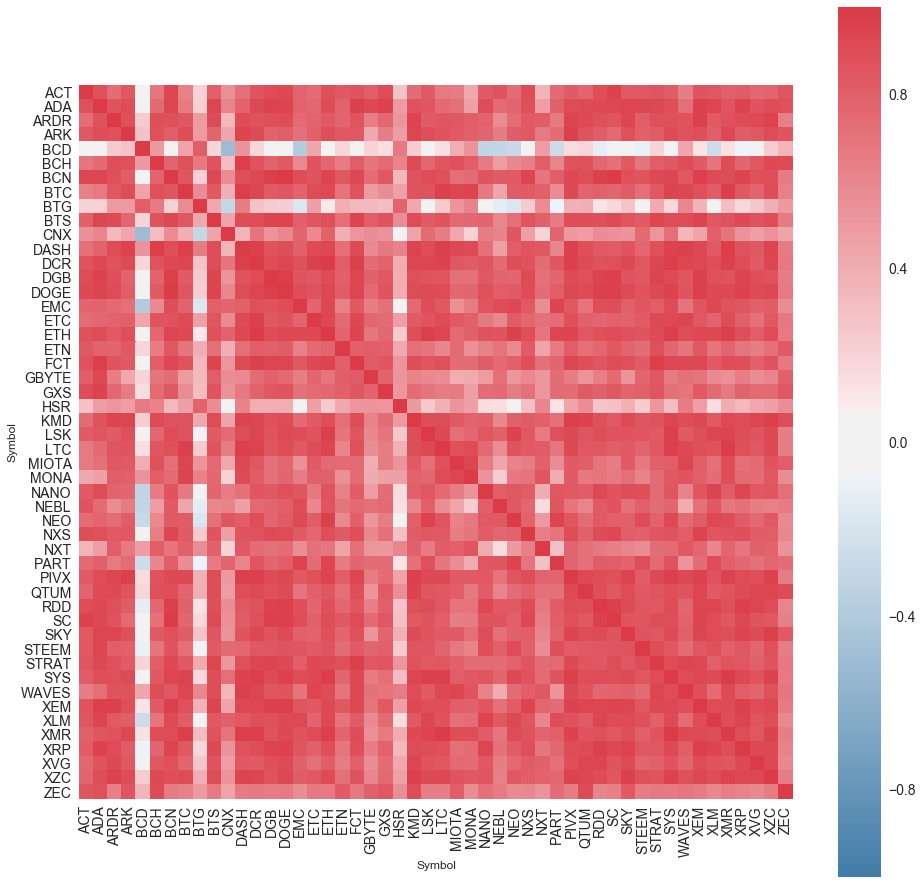

In [8]:
top50_pivot_df = top50_currencies_df.pivot(index='Date', columns='Symbol', values='Close')
top50_corr = top50_pivot_df.corr()

cmap = sns.diverging_palette(240, 10,sep=20, as_cmap=True)

plt.figure(figsize = (16,16))
plt.tight_layout()
sns.heatmap(top50_corr, 
            xticklabels=top50_corr.columns.values,
            yticklabels=top50_corr.columns.values, 
            cmap=cmap, vmin=-1, vmax=1, annot=False, square=True)

Overall it looks like a very highly correlated space. A few notable exceptions are BCD (Bitcoin Diamond), BTG (Bitcoin Gold), CNX (Cryptonex), HSR (Hshare), POA (POA Network). I have not heard of any of these except for Bitcoin Gold. It could be that they have only recently come into existence and therefore are experiecing the initial insane volatility followed by being newly listed. Lets have a look at their stats.

In [10]:
latest_date = max(top50_currencies_df['Date'])
top50_currencies_latest_df = top50_currencies_df[top50_currencies_df['Date'] == latest_date]
corr_outliers_df = top50_currencies_latest_df[top50_currencies_latest_df['Symbol'].isin(['BCD', 'BTG', 'CNX', 'HSR', 'POA'])]
corr_outliers_df

,Unnamed: 0,Date,Symbol,Open,High,Low,Close,Volume,Market Cap,rank
202116,176,2018-04-05,CNX,4.81,4.93,4.44,4.69,1196660.0,217478000.0,32.0
304213,164,2018-04-05,BTG,42.14,43.34,39.80,41.59,15492900.0,713158000.0,17.0
396839,132,2018-04-05,BCD,2.27,2.28,1.93,2.18,2982490.0,347501000.0,26.0
594251,228,2018-04-05,HSR,5.28,5.39,5.16,5.36,14967700.0,226012000.0,31.0


In [11]:
top50_start_dates = top50_currencies_df.loc[top50_currencies_df.groupby('Symbol')['Date'].idxmin()]
corr_outliers_df = top50_start_dates[top50_start_dates['Symbol'].isin(['BCD', 'BTG', 'CNX', 'HSR', 'POA'])]
corr_outliers_df

,Unnamed: 0,Date,Symbol,Open,High,Low,Close,Volume,Market Cap,rank
396707,0,2017-11-24,BCD,61.71,74.44,61.71,69.30,23322800.0,NaN,26.0
304049,0,2017-10-23,BTG,479.82,539.72,479.82,500.13,7652060.0,NaN,17.0
201940,0,2017-10-07,CNX,2.70,2.70,2.70,2.70,79554.0,NaN,32.0
594023,0,2017-08-20,HSR,20.38,20.58,18.98,20.37,6789300.0,NaN,31.0


It looks like our theory is plausible - all five currencies that look like they are breaking the trends have their start date later than mid 2017 and could still be in their "new currency going insane" phase.

Lets narrow our analysis down to the top 20 in the hope of eliminating extremely new currencies and do the plot again. We will also set the minimum value to 0 in order to get a larger colour differentiation between correlations.

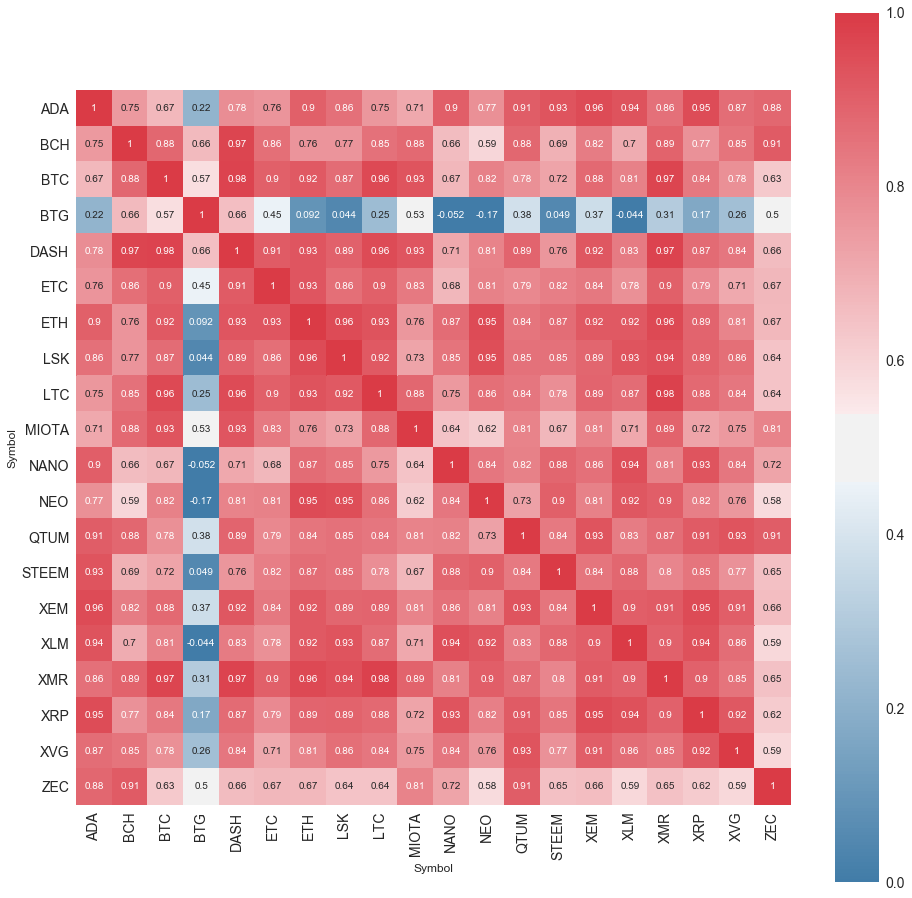

In [13]:
top20_currencies_df = all_currencies_df[all_currencies_df['rank'] <= 20]

top20_pivot_df = top20_currencies_df.pivot(index='Date', columns='Symbol', values='Close')
top20_corr = top20_pivot_df.corr()

cmap = sns.diverging_palette(240, 10,sep=20, as_cmap=True)

plt.figure(figsize = (16,16))
plt.tight_layout()
sns.heatmap(top20_corr, 
            xticklabels=top20_corr.columns.values,
            yticklabels=top20_corr.columns.values, 
            cmap=cmap, vmin=0, vmax=1, annot=True, square=True)

Using this zoomed-in colour differentiation we now notice the next largest "trend-breaker", ZEC. Which is not really a trend-breaker, still having a correlations between 0.58 and 0.91 with other top 20 currencies.

Daily Percent Change 
Ok, this is a little disappointing as I was hoping to be able to identify more independent movement between cryptocurrencies in order to fulfil the goals of this notebook. However, lets proceed anyway and try to get a better picture of the volatility within the crypto space.

In [15]:
# Reshape the dataframe to multiindex by Date and currency
top50_currencies_df.set_index(['Symbol', 'Date'], inplace=True) # Or should it be the other way around?
top50_currencies_df.head()

Unnamed: 0      Open      High       Low     Close  \
Symbol Date                                                             
DASH   2014-02-14           0  0.213899  0.378883  0.213899  0.374024   
       2014-02-15           1  0.331111  0.354461  0.219434  0.314865   
       2014-02-16           2  0.325840  0.459833  0.310345  0.406976   
       2014-02-17           3  0.406039  1.500000  0.402588  1.450000   
       2014-02-18           4  1.180000  1.500000  0.841751  1.040000   

                     Volume  Market Cap  rank  
Symbol Date                                    
DASH   2014-02-14   15422.0    702537.0  11.0  
       2014-02-15   21119.0   1092120.0  11.0  
       2014-02-16   28017.0   1085280.0  11.0  
       2014-02-17  178618.0   1360260.0  11.0  
       2014-02-18  160779.0   3960320.0  11.0

In [16]:
# Get daily percent change in close price
top50_currencies_df['pct_change'] = top50_currencies_df['Close'].groupby(level=0).pct_change()
top50_currencies_df.head()

Unnamed: 0      Open      High       Low     Close  \
Symbol Date                                                             
DASH   2014-02-14           0  0.213899  0.378883  0.213899  0.374024   
       2014-02-15           1  0.331111  0.354461  0.219434  0.314865   
       2014-02-16           2  0.325840  0.459833  0.310345  0.406976   
       2014-02-17           3  0.406039  1.500000  0.402588  1.450000   
       2014-02-18           4  1.180000  1.500000  0.841751  1.040000   

                     Volume  Market Cap  rank  pct_change  
Symbol Date                                                
DASH   2014-02-14   15422.0    702537.0  11.0         NaN  
       2014-02-15   21119.0   1092120.0  11.0   -0.158169  
       2014-02-16   28017.0   1085280.0  11.0    0.292541  
       2014-02-17  178618.0   1360260.0  11.0    2.562864  
       2014-02-18  160779.0   3960320.0  11.0   -0.282759

In [17]:
# Plot daily percentage change for BTC
btc_df = top50_currencies_df.xs('BTC')
btc_df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,Market Cap,rank,pct_change
Date,,,,,,,,,
2013-04-28,0,135.30,135.98,132.10,134.21,NaN,1.500520e+09,1.0,NaN
2013-04-29,1,134.44,147.49,134.00,144.54,NaN,1.491160e+09,1.0,0.076969
2013-04-30,2,144.00,146.93,134.05,139.00,NaN,1.597780e+09,1.0,-0.038328
2013-05-01,3,139.00,139.89,107.72,116.99,NaN,1.542820e+09,1.0,-0.158345
2013-05-02,4,116.38,125.60,92.28,105.21,NaN,1.292190e+09,1.0,-0.100692


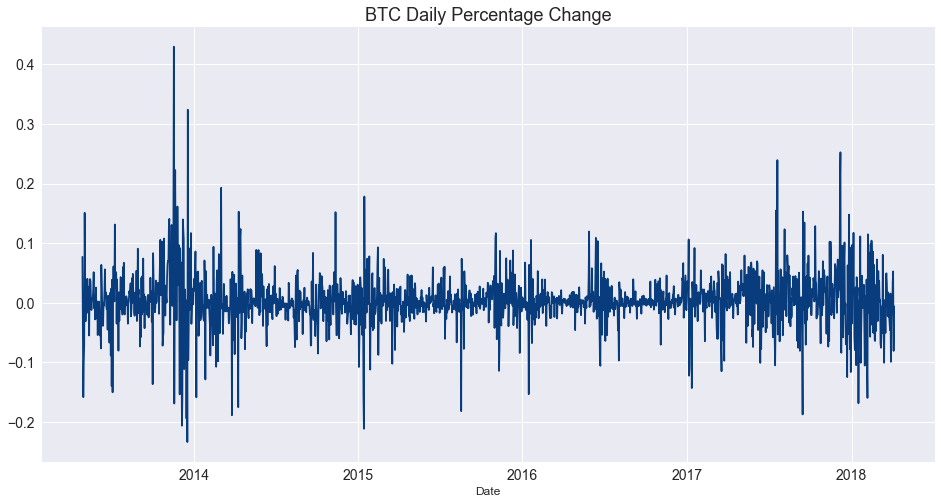

In [18]:
btc_df['pct_change'].plot(figsize=(16,8), title='BTC Daily Percentage Change')
plt.savefig('bitcoin_daily_pct_change.png')

Calculating Variance 
Lets go with a 30 day variance calculation. That means that assigned to each day will be the average variance of the movements of the 50 chosen stocks over the last 30 days. This should give us a longer-term view of the market vs. fundamentals tension.

Method:

Calculate the mean price for the number of periods/observations
Determine each period's deviation (close minus average price)
Variance = sum of the squared deviations, divided by the number of observations (- Standard deviation = square root of variance)

In [20]:
# calculate mean price over the past 30 days
top50_currencies_df['ma_30'] = top50_currencies_df['pct_change'].rolling(window=30).mean()

top50_currencies_df['deviation'] = top50_currencies_df['pct_change'] - top50_currencies_df['ma_30']

top50_currencies_df['variance'] = top50_currencies_df['deviation']**2 / 30

top50_currencies_df.sample(5)

,,Unnamed: 0,Open,High,Low,Close,Volume,Market Cap,rank,pct_change,ma_30,deviation,variance
Symbol,Date,,,,,,,,,,,,
DGB,2014-02-24,18,0.000367,0.000368,0.000331,0.000333,1230.0,223660.0,36.0,-0.092643,NaN,NaN,NaN
MONA,2017-08-06,1206,0.473617,0.491749,0.468607,0.472409,57136.0,25114000.0,35.0,0.000229,-0.009872,0.010101,0.000003
STRAT,2017-01-01,142,0.072355,0.075303,0.070218,0.072378,24800.0,7106110.0,25.0,-0.000732,0.015439,-0.016171,0.000009
XVG,2017-10-02,1073,0.007120,0.008139,0.007120,0.007260,8516350.0,95480400.0,16.0,0.006935,0.017486,-0.010551,0.000004
BCN,2016-04-02,655,0.000050,0.000093,0.000046,0.000067,87281.0,8937080.0,21.0,0.340000,0.034282,0.305718,0.003115


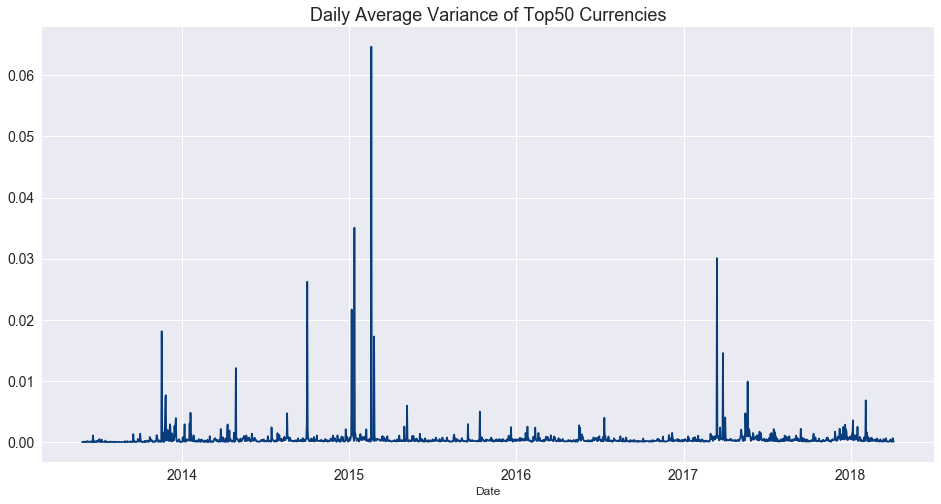

In [21]:
top50_average_variance_df = top50_currencies_df['variance'].groupby('Date').mean()
top50_average_variance_df.plot(figsize=(16,8), title='Daily Average Variance of Top50 Currencies')

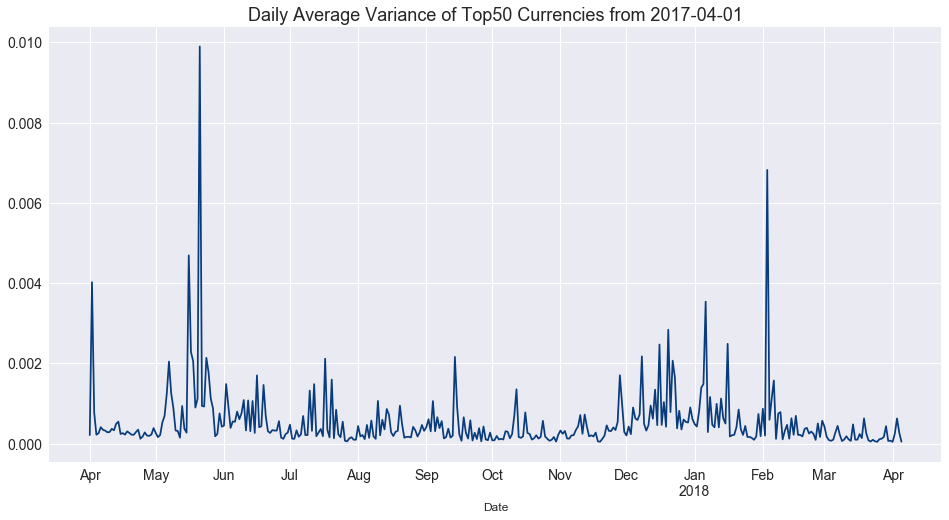

In [22]:
# Lets look at just the past year
top50_average_variance_df = top50_average_variance_df.loc['2017-04-01':]
top50_average_variance_df.plot(figsize=(16,8), title='Daily Average Variance of Top50 Currencies from 2017-04-01')

This shows that the variance in stock movements for the last month has been the lowest since mid October last year, indicating that stocks are moving in the same direction more so than in the previous six months. This kind of analysis helps us put weights on the utility of stock-specific data versus market-specific data.

Crypto20 Market Cap Index 
Another way to get an easy comparison of how any particular currency is moving relative to the market is to build an index to compare it to. An index will also be able to show trends and changes in investing patterns much better than looking at Bitcoin or a handfull of other currencies on their own, which up until recently might have been fine given Bitcoin's dominance.

We can calculate a crypto index, lets make it crypto20 (Because the crypto space is so volatile that taking the top 50 would result in too many changes to cryptocurrencies needing to be included in the index), using weighted average market capitalisation (following the S&P 500 method).

Get top 20 currencies by marketcap
For each row (day, currency) calculate the market weight -> #outstanding units * price / (total market cap)
Calculate an index divisor -> eg: divisor = total market cap / 100 would give us a 100 point starting index

In [24]:
top20_currencies_df = all_currencies_df[all_currencies_df['rank'] <= 20]
top20_start_dates = top20_currencies_df.loc[top20_currencies_df.groupby('Symbol')['Date'].idxmin()]
start_date = max(top20_start_dates.Date)

In [25]:
# Lets start this index at the earliest date when the top 20 cryptos all existed
top20_start_dates = top20_currencies_df.loc[top20_currencies_df.groupby('Symbol')['Date'].idxmin()]

In [26]:
# Determine index start date
start_date = max(top20_start_dates['Date'])
start_date

Timestamp('2017-10-23 00:00:00')

In [27]:
# Remove all older data
index_currencies_df = top20_currencies_df[(top20_currencies_df['Date'] >= start_date)]
index_currencies_df.sample()

,Unnamed: 0,Date,Symbol,Open,High,Low,Close,Volume,Market Cap,rank
304151,102,2018-02-02,BTG,127.89,127.89,89.15,110.22,84321300.0,2.148410e+09,17.0


In [28]:
# Detemine index divisor at the start date 
crypto20_index_divisor = index_currencies_df[index_currencies_df['Date']==start_date]['Market Cap'].sum() / 100
crypto20_index_divisor

1567348442.0

In [29]:
# Build the index
def calculate_index_value(df_sub):
    return df_sub['Market Cap'].sum() / crypto20_index_divisor

crypto20_index_df = index_currencies_df.groupby('Date').apply(calculate_index_value)
crypto20_index_df.head()

Date
2017-10-23    100.000000
2017-10-24     98.188318
2017-10-25     95.537424
2017-10-26     97.732422
2017-10-27     99.185870
dtype: float64

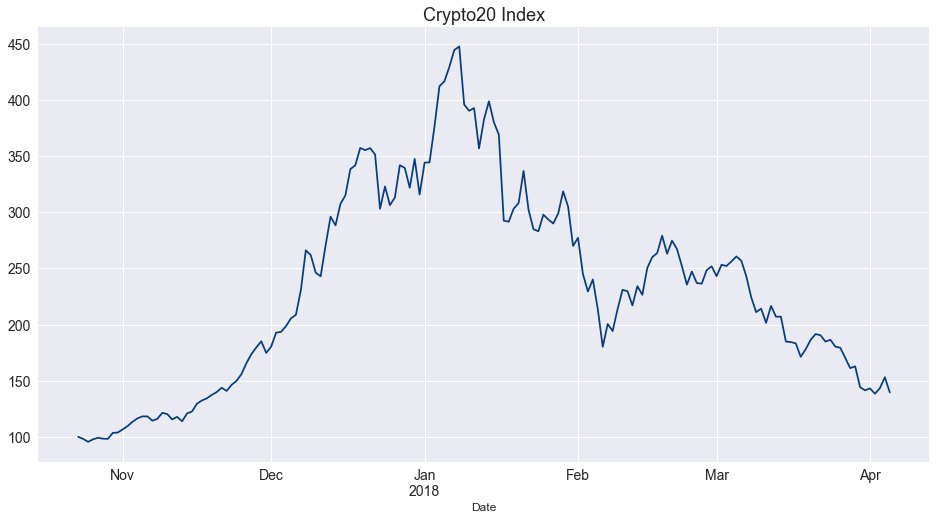

In [30]:
crypto20_index_df.plot(figsize=(16,8), title='Crypto20 Index')

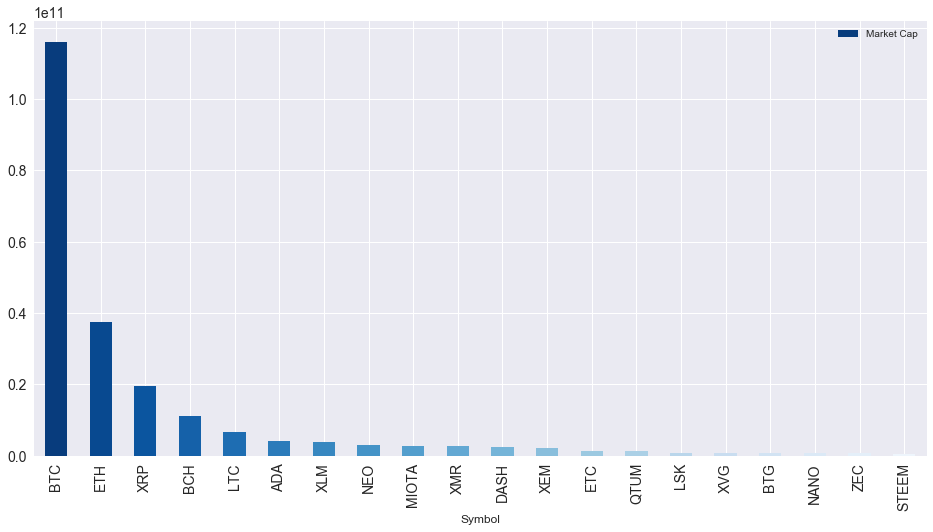

In [31]:
# Lets see just how much influence BTC has on this index
top20_latest_df = top20_currencies_df[all_currencies_df['Date'] == last_date]
top20_latest_df.sort_values(by='Market Cap',ascending=False).plot(x='Symbol', y='Market Cap', kind='bar', figsize=(16,8))

It looks like BTC dominates the index so much that the rest almost fade into insignificance.

# Crypto20 Equal Weight Index
Although market cap indices are the most popular, it is not always the best way to examine movements, especially when a single currency dominates the whole index. Another option is an equal weight index, where all currencies are weighted equally. Lets build this with the top 20 cryptocurrencies and see what it looks like.

In [33]:
# Detemine initial amount of each currency assuming an index starting value of 100
n = 20
index_currencies_start_df = index_currencies_df[index_currencies_df['Date']==start_date]
index_currencies_start_df['eq_index_holdings'] = 100 / n / index_currencies_start_df['Close']

In [34]:
# Add eq_index_holdings column to index_currencies_df
index_currencies_df = pd.merge(left=index_currencies_df,right=index_currencies_start_df[['Symbol', 'eq_index_holdings']], how='left', left_on='Symbol', right_on='Symbol')
# Calculate the value for each date/Currency
index_currencies_df['eq_index_holdings_value'] = index_currencies_df['eq_index_holdings']*index_currencies_df['Close']


In [35]:
# Build index
crypto20eq_index_df = index_currencies_df.groupby('Date')['eq_index_holdings_value'].sum()
crypto20eq_index_df.head()

Date
2017-10-23    100.000000
2017-10-24    102.797756
2017-10-25    101.673249
2017-10-26    100.832694
2017-10-27    100.794631
Name: eq_index_holdings_value, dtype: float64

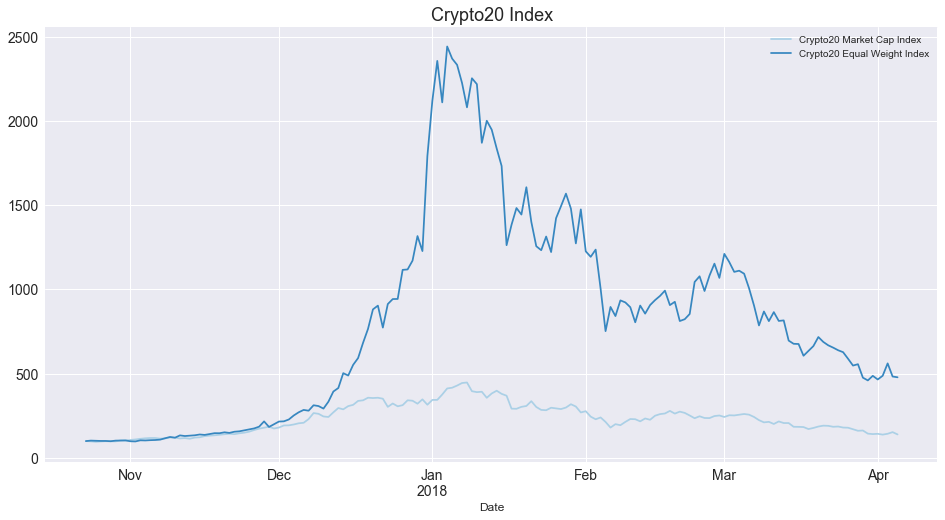

In [36]:
with sns.color_palette("Blues", 2):
    ax = crypto20_index_df.plot(figsize=(16,8), title='Crypto20 Index', label='Crypto20 Market Cap Index', legend=True)
    crypto20eq_index_df.plot(ax=ax, label='Crypto20 Equal Weight Index', legend=True)

The market cap index dominated by Bitcoin looks so stable in comparison to the equal weight index, where each top 20 currency has an equal weighting!

# Beta Calculation
A common measure of a stock’s volatility relative to the broader market is known as the stock’s beta. This number compares the movements of an individual security against those of a benchmark index, which is assigned a beta of 1. For example, a stock with a beta value of 1.2 has historically moved 120 percent for every 100 percent move in a benchmark index such as the S&P 500. We can apply this to cryptocurrencies and calcualte the beta for a currency by measuring its movement against the Crypto20 Index. To calculate the beta we need to calculate the covariance between the return of the crypto and the market return, and then divide it by the variance of market returns.

Lets use a monthly period for variance calculations and use the same calculation method (previously outlined) for the equal weighted index.

In [38]:
crypto20eq_index_df = crypto20eq_index_df.reset_index()
crypto20eq_index_df.head()

,Date,eq_index_holdings_value
0,2017-10-23,100.000000
1,2017-10-24,102.797756
2,2017-10-25,101.673249
3,2017-10-26,100.832694
4,2017-10-27,100.794631


In [39]:
# Crypto - We already have top50_currencies_df['pct_change'] from a previous step

# calculate the market variance based on the Crypto20 Equal Weight Index
crypto20eq_index_df['pct_change'] = crypto20eq_index_df['eq_index_holdings_value'].pct_change()

crypto20eq_index_df['ma_30'] = crypto20eq_index_df['pct_change'].rolling(window=30).mean()

crypto20eq_index_df['deviation'] = crypto20eq_index_df['pct_change'] - crypto20eq_index_df['ma_30']

crypto20eq_index_df['variance'] = crypto20eq_index_df['deviation']**2 / 30
crypto20eq_index_df.tail()

,Date,eq_index_holdings_value,pct_change,ma_30,deviation,variance
160,2018-04-01,465.483342,-0.044526,-0.027977,-0.016548,0.000009
161,2018-04-02,487.719496,0.047770,-0.024714,0.072484,0.000175
162,2018-04-03,561.027171,0.150307,-0.019916,0.170224,0.000966
163,2018-04-04,483.172232,-0.138772,-0.024008,-0.114764,0.000439
164,2018-04-05,478.509601,-0.009650,-0.021681,0.012031,0.000005


In [40]:
# calculate the covariance between the return of the crypto and the market return

#better way to join than resetting index?
top50_currencies_df = top50_currencies_df.reset_index()

# covariance
# This is probably not the most efficient way of achieving this calculation. If any python experts out there know a better way please let me know. In principle rolling windows across multiple dataframes?
top50_currencies_df =  pd.merge(left=top50_currencies_df,right=crypto20eq_index_df[['Date', 'pct_change', 'ma_30', 'deviation']], how='left', left_on='Date', right_on='Date')
top50_currencies_df['product'] = top50_currencies_df['deviation_x']*top50_currencies_df['deviation_y']


top50_currencies_df.tail()


,Symbol,Date,Unnamed: 0,Open,High,Low,Close,Volume,Market Cap,rank,pct_change_x,ma_30_x,deviation_x,variance,pct_change_y,ma_30_y,deviation_y,product
40890,BCH,2018-04-01,252,688.01,699.05,629.93,643.03,318440000.0,1.172960e+10,4.0,-0.061613,-0.020968,-0.040645,0.000055,-0.044526,-0.027977,-0.016548,0.000673
40891,BCH,2018-04-02,253,644.46,686.02,641.43,662.77,282036000.0,1.098830e+10,4.0,0.030698,-0.019819,0.050518,0.000085,0.047770,-0.024714,0.072484,0.003662
40892,BCH,2018-04-03,254,664.15,719.77,660.35,712.88,303771000.0,1.132510e+10,4.0,0.075607,-0.017790,0.093397,0.000291,0.150307,-0.019916,0.170224,0.015898
40893,BCH,2018-04-04,255,710.47,711.27,638.01,649.20,282960000.0,1.211630e+10,4.0,-0.089328,-0.020223,-0.069105,0.000159,-0.138772,-0.024008,-0.114764,0.007931
40894,BCH,2018-04-05,256,648.63,655.52,620.10,646.04,243989000.0,1.106280e+10,4.0,-0.004868,-0.018756,0.013888,0.000006,-0.009650,-0.021681,0.012031,0.000167


In [41]:
top50_currencies_df['covariance'] = top50_currencies_df['product'].rolling(window=30).sum()/29
top50_currencies_df.tail()

,Symbol,Date,Unnamed: 0,Open,High,Low,Close,Volume,Market Cap,rank,pct_change_x,ma_30_x,deviation_x,variance,pct_change_y,ma_30_y,deviation_y,product,covariance
40890,BCH,2018-04-01,252,688.01,699.05,629.93,643.03,318440000.0,1.172960e+10,4.0,-0.061613,-0.020968,-0.040645,0.000055,-0.044526,-0.027977,-0.016548,0.000673,0.003201
40891,BCH,2018-04-02,253,644.46,686.02,641.43,662.77,282036000.0,1.098830e+10,4.0,0.030698,-0.019819,0.050518,0.000085,0.047770,-0.024714,0.072484,0.003662,0.003313
40892,BCH,2018-04-03,254,664.15,719.77,660.35,712.88,303771000.0,1.132510e+10,4.0,0.075607,-0.017790,0.093397,0.000291,0.150307,-0.019916,0.170224,0.015898,0.003861
40893,BCH,2018-04-04,255,710.47,711.27,638.01,649.20,282960000.0,1.211630e+10,4.0,-0.089328,-0.020223,-0.069105,0.000159,-0.138772,-0.024008,-0.114764,0.007931,0.004122
40894,BCH,2018-04-05,256,648.63,655.52,620.10,646.04,243989000.0,1.106280e+10,4.0,-0.004868,-0.018756,0.013888,0.000006,-0.009650,-0.021681,0.012031,0.000167,0.003971


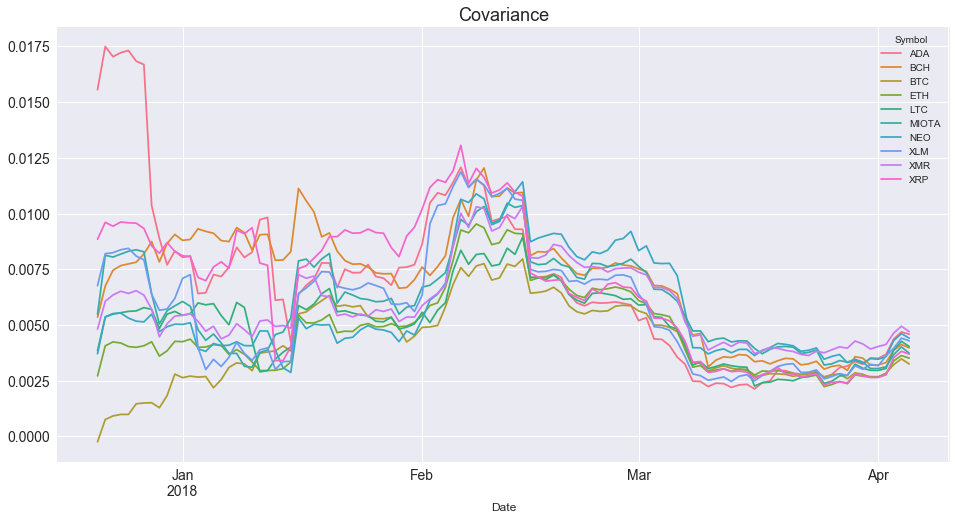

In [42]:
# Plot the covariance
# Split into top10, middle20, bottom20 because the plots become too cluttered to read otherwise.
top_currencies_df = top50_currencies_df[top50_currencies_df['rank'] <= 10]
mid_currencies_df = top50_currencies_df[(top50_currencies_df['rank'] > 10) & (top50_currencies_df['rank'] <= 30)]
bottom_currencies_df = top50_currencies_df[top50_currencies_df['rank'] > 30]

top_currencies_cov_df = top_currencies_df.pivot(index='Date', columns='Symbol', values='covariance')

with sns.color_palette("husl", 10):
    top_currencies_cov_df.plot(figsize=(16,8), title='Covariance')

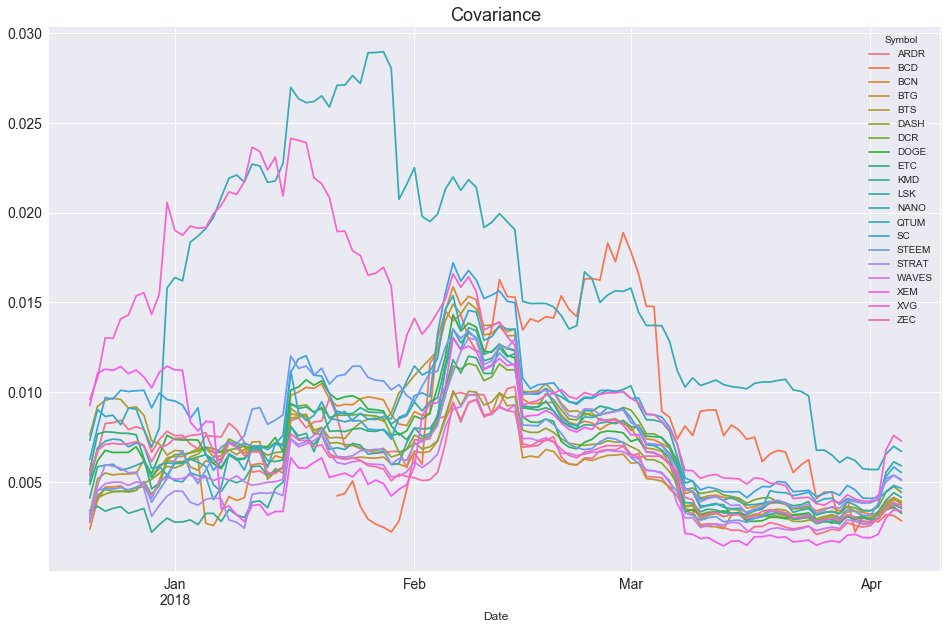

In [43]:
mid_currencies_cov_df = mid_currencies_df.pivot(index='Date', columns='Symbol', values='covariance')

with sns.color_palette("husl", 20):
    mid_currencies_cov_df.plot(figsize=(16,10), title='Covariance')

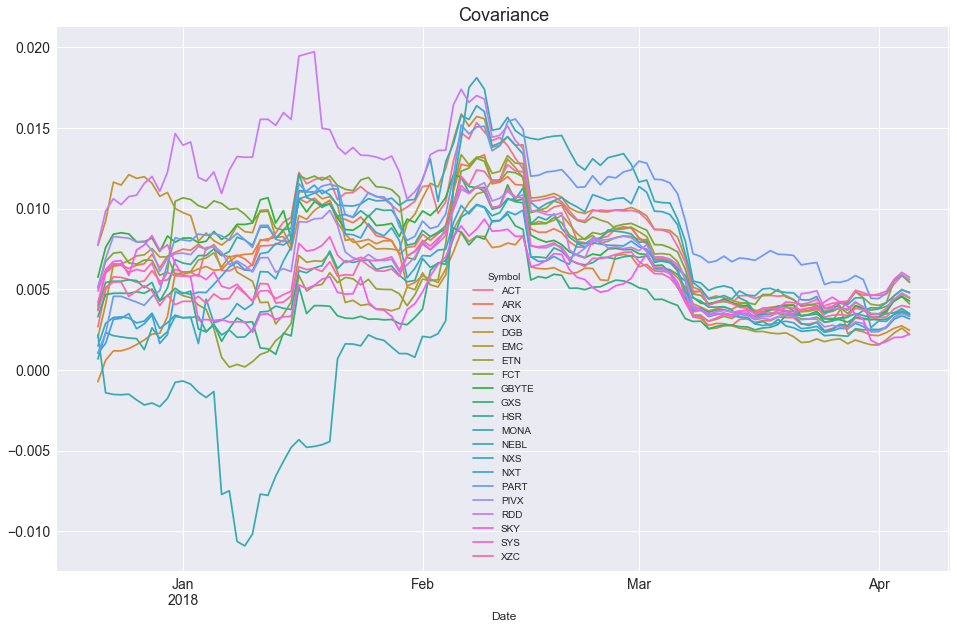

In [44]:
bottom_currencies_cov_df = bottom_currencies_df.pivot(index='Date', columns='Symbol', values='covariance')

with sns.color_palette("husl", 20):
    bottom_currencies_cov_df.plot(figsize=(16,10), title='Covariance')

In the stock market, a strong emphasis is placed on reducing the risk amount taken on for the same amount of return. When constructing a portfolio, an analyst will select stocks that will work well together. This usually means that these stocks do not move in the same direction. This could prove quite difficult for the cryptocurrency market, as it currently seems like most of the top cryptocurrencies move with the market. They have yet to develop their own strong identities.